# **Fake News Detection (Natural Language Processing)**

## **Installing Necessary Packages**

In [21]:
!pip install scikit-learn matplotlib seaborn nltk shap streamlit

## **Importing Necessary Libraries**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap
import string
import re
import pickle
import warnings
warnings.filterwarnings("ignore")

## **Downloading NLTK Resources**

In [28]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Loading the Dataset**

In [29]:
df = pd.read_csv("news.csv")
print(df.head())  # printing the first 5 rows

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


## **Data Preprocessing**

In [30]:
def preprocess_text(text):
    # converting text to lowercase
    text = text.lower()
    # removing digits from the text
    text = re.sub(r'\d+', '', text)
    # removing punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenizing the text into words
    tokens = word_tokenize(text)
    # getting a set of English stop words
    stop_words = set(stopwords.words('english'))
    # filtering out stop words from the token list
    filtered = [w for w in tokens if w not in stop_words]
    # joining the filtered tokens back into a single string
    return ' '.join(filtered)

# applying the preprocessing function to the 'text' column and storing it in 'text_clean'
df['text_clean'] = df['text'].apply(preprocess_text)

## **EDA**

Class Distribution:
 label
REAL    3171
FAKE    3164
Name: count, dtype: int64


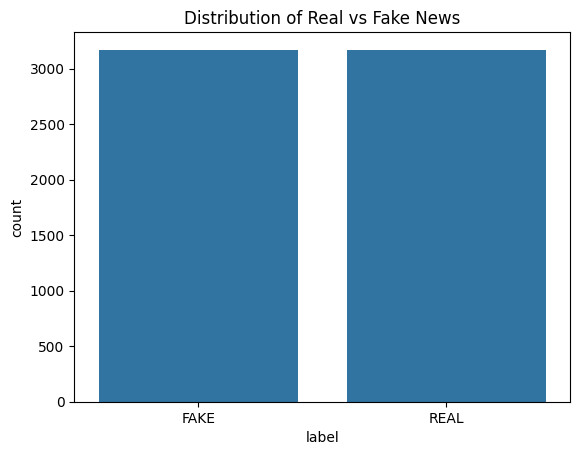

In [36]:
# printing the distribution of classes in the 'label' column
print("Class Distribution:\n", df['label'].value_counts())

# creating a count plot for the 'label' column
sns.countplot(data=df, x='label')

# setting the title of the plot
plt.title('Distribution of Real vs Fake News')

# displaying the plot
plt.show()

## **Dataset Splitting**

In [37]:
# assigning the cleaned text data to X
X = df['text_clean']

# assigning the labels to y
y = df['label']

# splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **TF-IDF Vectorization**

In [38]:
# initializing the TF-IDF Vectorizer with a maximum of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# fitting the TF-IDF on the training data and transforming it
X_train_tfidf = tfidf.fit_transform(X_train)

# transforming the test data using the already fitted TF-IDF
X_test_tfidf = tfidf.transform(X_test)

## **Model Training**

In [39]:
# initializing the logistic regression model
model = LogisticRegression()

# training the model on the TF-IDF-transformed training data
model.fit(X_train_tfidf, y_train)

LogisticRegression()

## **Model Evaluation**

Accuracy: 0.9194948697711128
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.91      0.93      0.92       628
        REAL       0.93      0.91      0.92       639

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



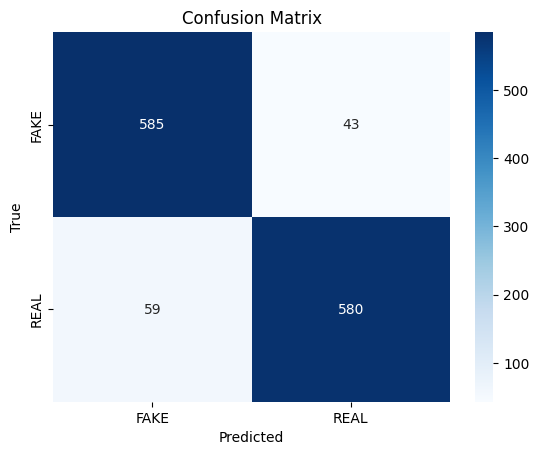

In [40]:
# making predictions on the test data
y_pred = model.predict(X_test_tfidf)

# printing the accuracy score of the model
print("Accuracy:", accuracy_score(y_test, y_pred))

# printing the classification report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plotting the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])

# labeling the x-axis
plt.xlabel('Predicted')

# labeling the y-axis
plt.ylabel('True')

# setting the title of the plot
plt.title('Confusion Matrix')

# displaying the plot
plt.show()

## **Saving Model and Vectorizer for Deployment**

In [41]:
# saving the trained logistic regression model
with open("logreg_model.pkl", "wb") as f:
    pickle.dump(model, f)

# saving the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

## **Ensemble Model with Voting Classifier**

In [42]:
# initializing the Voting Classifier with logistic regression, multinomial Naive Bayes, and random forest classifiers
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('nb', MultinomialNB()),
    ('rf', RandomForestClassifier(n_estimators=100))
], voting='soft')

# training the ensemble model on the TF-IDF transformed training data
ensemble_model.fit(X_train_tfidf, y_train)

# making predictions with the ensemble model on the test data
y_ensemble_pred = ensemble_model.predict(X_test_tfidf)

# printing the accuracy score of the ensemble model
print("Ensemble Accuracy:", accuracy_score(y_test, y_ensemble_pred))

Ensemble Accuracy: 0.930544593528019


## **SHAP Interpretability**

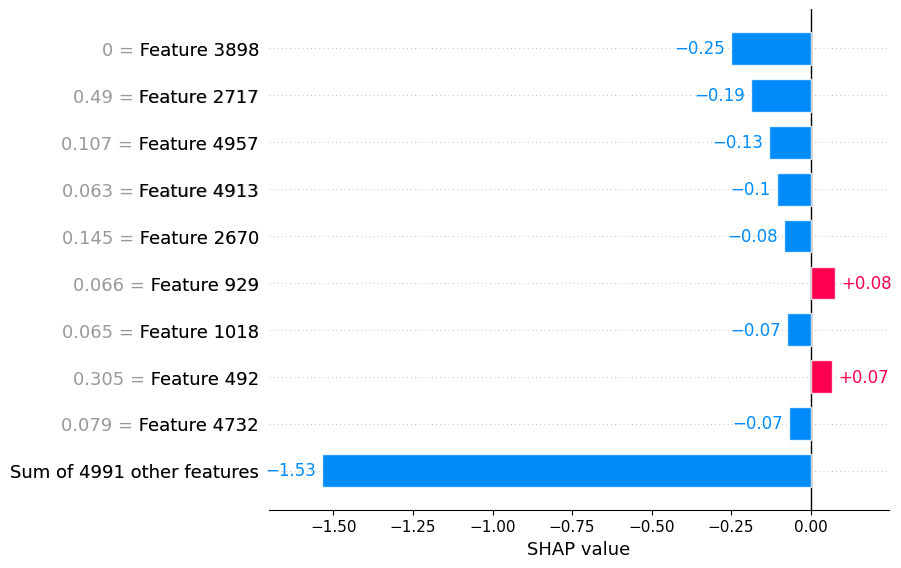

In [43]:
# creating a SHAP explainer for the trained model using the first 100 samples of the training data
explainer = shap.Explainer(model, X_train_tfidf[:100])

# calculating the SHAP values for the first test sample
shap_values = explainer(X_test_tfidf[:1])

# initializing JavaScript visualization for SHAP plots
shap.initjs()

# plotting a bar plot of SHAP values for the first test sample
shap.plots.bar(shap_values[0])